# Mouse Simulator


This agent represents a very simple mouse who maintains a generative bayesian model of its world consisting of 2 normal distributions and a non-linear transformation g(x) = x^2. The mouse's sensations of its world are very simplistic: it only has a single sensor that generates a scalar value representing light intensity.


Running mouse simulator for 100000 steps...
------------------------------------------------


Text(0.5, 1.0, 'Mouse beliefs over time')

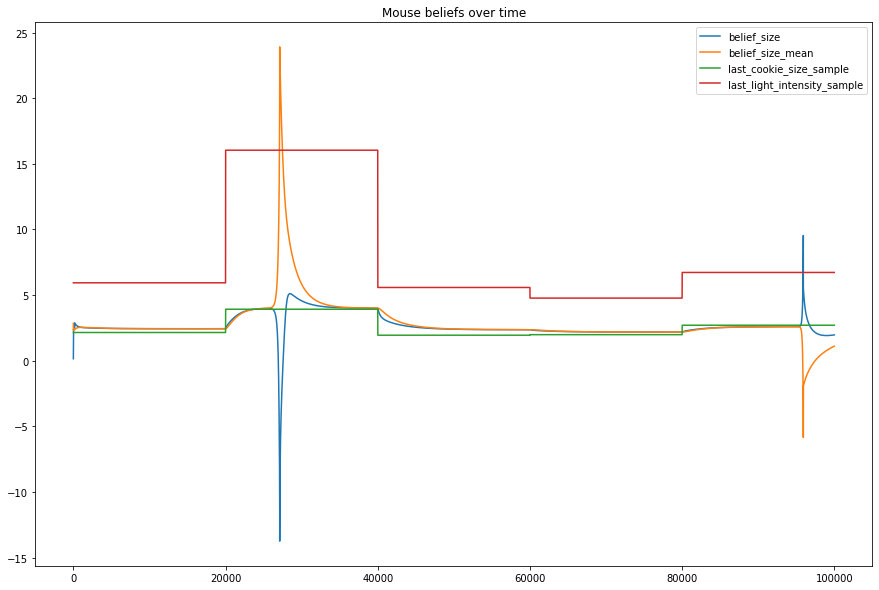

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, Overflow
from collections import defaultdict

np.random.seed(47)

env_stats = defaultdict(list)
mouse_stats = defaultdict(list)

# CookieSensorEnv represents a world that has a cookie and a sensor in it.
# In this world, only one cookie exists at a time, and that cookie
# reflects light as a function of its size.
# An agent senses the light bouncing off the cookie by calling step(),
# which returns a scalar representing light intensity.
# Cookie size is random, determined by a normal distribution with
# with parameters specified via __init__() or left to their default values.
# Sensor output is also random, specified by a 2nd normal distribution,
# with mean set to a function g(x) of the output of the cookie_size
# distribution, and variance specified via __init__(). To summarize the flow:
# 0) an agent calls step() on this env, receives a sample of light_intensity
#    generated per the following:
# 1) a cookie is generated with a random size per normal dist. with user
#    provided mean and variance.
# 2) size transformed and used as light_mean via: light_mean = g(size) = size^2
# 3) a sensor reading is generated and returned with random intensity per
#    normal distribution using light_mean as mean and user provided variance.
class CookieSensorEnv:
    def __init__(self,
                 cookie_size_mean=3,
                 cookie_size_var=1,
                 area_to_light_fn=lambda x: x*x,
                 light_intensity_var=1,
                 new_cookie_period=20000):
        self.cookie_size_mean = Decimal(cookie_size_mean)
        self.cookie_size_var = Decimal(cookie_size_var)
        self.area_to_light_fn = area_to_light_fn
        self.light_intensity_var = Decimal(light_intensity_var)

        self.new_cookie_period = new_cookie_period
        self.cookie_period_counter = 0        
        self.last_cookie_size_sample = None
        self.last_light_intensity_mean = 0
        self.last_light_intensity_sample = None

    # No actions accepted
    # Returns light intensity at this timestep.
    def step(self, action):
        assert not action
        if self.last_light_intensity_sample is None or self.cookie_period_counter >= self.new_cookie_period:
            self.cookie_period_counter = 0
            self.last_cookie_size_sample = np.random.normal(self.cookie_size_mean, self.cookie_size_var)
            self.last_light_intensity_mean = self.area_to_light_fn(self.last_cookie_size_sample)
            self.last_light_intensity_sample = Decimal(np.random.normal(self.last_light_intensity_mean, self.light_intensity_var))
        self.cookie_period_counter += 1
        
        #env_stats["cookie_size_mean"].append(self.cookie_size_mean)
        #env_stats["cookie_size_var"].append(self.cookie_size_var)
        env_stats["last_cookie_size_sample"].append(self.last_cookie_size_sample)
        #env_stats["last_light_intensity_mean"].append(self.last_light_intensity_mean)
        env_stats["last_light_intensity_sample"].append(self.last_light_intensity_sample)
        return self.last_light_intensity_sample, 0, False, {}

    
# The mouse brain has variables to track its beliefs about the world.
# Beliefs consist of estimates of the parameters in the environment,
# which from the mouses point of view are latent variables that must
# be learned through repeated experience of the end result of the physical
# processes, namely the output of the mouses noisy light sensor (its eye).
#
# These variables fall roughly into two categories:
# 1) beliefs that can be updated quickly in response to sensory input
#    such as the belief that a recently viewed cookie was 2cm.
#    These are analogous to the near-realtime changes to the output
#    of a Tensorflow DNN when new inputs are applied to it.
# 2) beliefs that evolve more slowly over time which in the brain
#    are implemented using synaptic plasticity, analogous to the way
#    params are updated via backprop in TensorFlow.
class Mouse:
    def __init__(self, env, steps=1):
        self.light_intensity_error_belief = Decimal(0)  # epsilon_u
        self.cookie_size_error_belief = Decimal(0)      # epsilon_p
        self.cookie_size_belief = Decimal(0)            # phi
        
        self.cookie_size_var_belief = Decimal(1)                     # sigma_p
        self.light_intensity_var_belief = Decimal(1)                 # sigma_u
        self.cookie_size_mean_belief = Decimal(3)                    # v_p
        self.area_to_light_belief_fn = lambda x: x**Decimal(2)       # g()
        self.area_to_light_deriv_belief_fn = lambda x: Decimal(2)*x  # g'()
      
        self.step_size = Decimal(0.05)
        self.env = env
        self.num_steps = 0
        while self.num_steps < steps:
            obs, reward, done, _ = self.env.step(None)
            self.update_world_model(obs)
            self.num_steps += 1
        
    def update_world_model(self, obs):
        try:
            # update neural network node vals (belief type 1)
            epsilon_p = (self.cookie_size_belief - self.cookie_size_mean_belief) / self.cookie_size_var_belief
            epsilon_u = (obs - self.area_to_light_belief_fn(self.cookie_size_belief)) / self.light_intensity_var_belief

            dF_dPhi = epsilon_u * self.area_to_light_deriv_belief_fn(self.cookie_size_belief) - epsilon_p     
            self.cookie_size_belief += self.step_size * dF_dPhi

            # update neural network synaptic weights (belief type 2)
            dF_dSigma_p = Decimal(0.5) * (epsilon_p**2 - 1 / self.cookie_size_var_belief)      # dF/dSigma_p
            dF_dSigma_u = Decimal(0.5) * (epsilon_u**2 - 1 / self.light_intensity_var_belief)  # dF/dSigma_u
            dF_dvp = epsilon_p                                                       # dF/dv_p

            self.cookie_size_var_belief += self.step_size * dF_dSigma_p
            self.light_intensity_var_belief += self.step_size * dF_dSigma_u
            self.cookie_size_mean_belief += self.step_size * dF_dvp


            # print updated neural network values
            #if self.num_steps % 100 == 0:
            #print(f"{self.num_steps:7}: e_p={epsilon_p:4.3}, e_u={epsilon_u:4.3}, " +
            #      f"size={self.cookie_size_belief:4.3}, " + 
            #      f"size_var={self.cookie_size_var_belief:4.3}, " +
            #      f"light_var={self.light_intensity_var_belief:4.3}, " + 
            #      f"size_mean={self.cookie_size_mean_belief:4.3}")

            #mouse_stats["e_p"].append(epsilon_p)
            #mouse_stats["e_u"].append(epsilon_u)
            mouse_stats["belief_size"].append(self.cookie_size_belief)
            mouse_stats["belief_size_var"].append(self.cookie_size_var_belief)
            mouse_stats["belief_light_var"].append(self.light_intensity_var_belief)
            mouse_stats["belief_size_mean"].append(self.cookie_size_mean_belief)
        except:
            return None


# Create a mouse agent and see what it learns as its best guess of the
# size of cookies it is seeing.
num_steps = 100000
print(f"Running mouse simulator for {num_steps} steps...")
print("------------------------------------------------")
Mouse(CookieSensorEnv(), steps=num_steps)

plt.figure(figsize=(15,10))
for k, v in mouse_stats.items():
    if k != "belief_light_var" and k != "belief_size_var":
        plt.plot(v, label=k)

for k, v in env_stats.items():
    plt.plot(v, label=k)

plt.legend()
plt.title("Mouse beliefs over time")


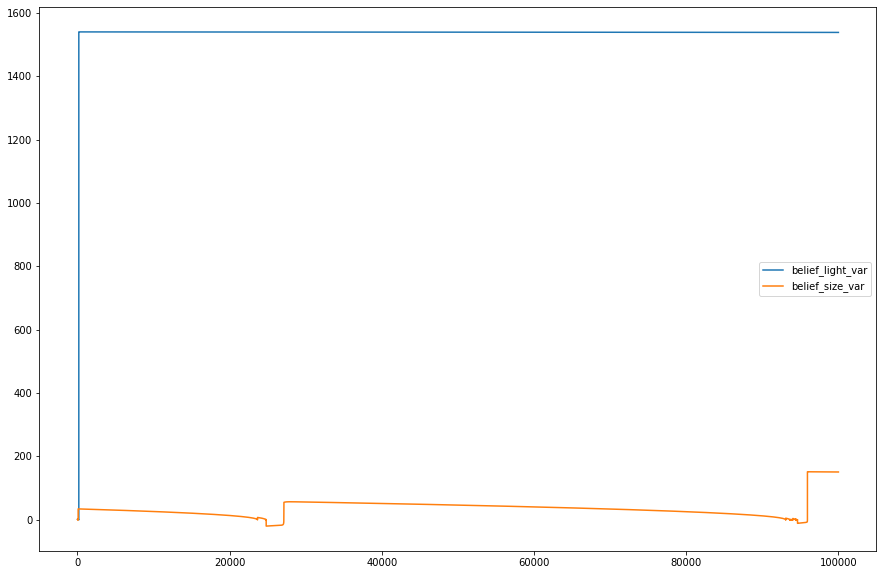

In [19]:
plt.figure(figsize=(15,10))
plt.plot(mouse_stats["belief_light_var"], label="belief_light_var")
plt.plot(mouse_stats["belief_size_var"], label="belief_size_var")
plt.legend()

In [89]:
import sys
sys.float_info.max

1.7976931348623157e+308